# Description
Analyse motility of infected cells from trackamte results such as, movement
speed and deviation from a straight path. To be used as simulation parameters
in Infectio.

# Part 1: Merge selected files into one DataFrame

In [1]:
import os
import numpy as np

CSV_ROOT = "../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061"
# include only files in range of 1 to 15 in their names, these are basic WR files
csv_files = [f for f in os.listdir(CSV_ROOT) if f.endswith(".csv") and int(f.split("-")[0]) in range(1, 16)]
csv_files

['5-spots.csv',
 '8-spots.csv',
 '3-spots.csv',
 '11-spots.csv',
 '4-spots.csv',
 '9-spots.csv',
 '2-spots.csv',
 '10-spots.csv',
 '7-spots.csv',
 '15-spots.csv',
 '1-spots.csv',
 '13-spots.csv',
 '6-spots.csv',
 '14-spots.csv',
 '12-spots.csv']

In [2]:
import pandas as pd

# Read the csv data in csv_files and only keep a selection of columns. Also add
# the number of in the file name to the TRACK_ID column with - in between
dfs = []
keep_cols = ["POSITION_X", "POSITION_Y", "FRAME", "TRACK_ID"]
for f in csv_files:
    df = pd.read_csv(os.path.join(CSV_ROOT, f), skiprows=[1, 2, 3], low_memory=False)
    df["TRACK_ID"] = f.split("-")[0] + '_' + df['TRACK_ID'].astype(str)
    df = df[keep_cols]
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Part 2: compute speed and inf time

In [3]:
# Add column to it called INF_TIME that for each track id finds the one with the
# lowest frame number and substracts this from the frame number for all entries
# with the same TRACK_ID
df["INF_TIME"] = df["FRAME"] - df.groupby("TRACK_ID")["FRAME"].transform(min)
df

,POSITION_X,POSITION_Y,FRAME,TRACK_ID,INF_TIME
0,1132.382298,780.356352,3,5_0,1
1,1157.079462,775.730682,15,5_0,13
2,1294.895209,694.547675,76,5_0,74
3,1333.355436,690.772999,107,5_0,105
4,1228.790624,742.486112,41,5_0,39
...,...,...,...,...,...
1772210,340.069011,1205.498086,167,12_4473,0
1772211,1903.866418,1243.627410,168,12_4474,1
1772212,1902.674698,1244.818465,167,12_4474,0
1772213,596.018710,1470.618648,168,12_4475,1


In [4]:
# Create new column called FORWARD_DIF_X that subtracks the value of POSITION_X
# with the value for the entry with same TRACK_ID but INF_TIME-1 (if INF_TIME is
# 0 then just put 0 in it)
df.sort_values(by=["TRACK_ID", "INF_TIME"], inplace=True)
df["BACKWARD_DIF_X"] = df.groupby("TRACK_ID")["POSITION_X"].diff().fillna(0)  # diff does the forward difference
df["BACKWARD_DIF_Y"] = df.groupby("TRACK_ID")["POSITION_Y"].diff().fillna(0)
df[df["TRACK_ID"] == "12_3000"][df["FRAME"] <= 145]

/var/folders/34/7vrvs7ts667_lxxqxdk42tlh0000gp/T/ipykernel_15561/2772475088.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["TRACK_ID"] == "12_3000"][df["FRAME"] <= 145]


,POSITION_X,POSITION_Y,FRAME,TRACK_ID,INF_TIME,BACKWARD_DIF_X,BACKWARD_DIF_Y
1746829,2121.950548,919.676756,136,12_3000,0,0.000000,0.000000
1746835,2119.156716,918.594289,137,12_3000,1,-2.793832,-1.082467
1746837,2116.808676,918.378199,138,12_3000,2,-2.348040,-0.216091
1746822,2114.230547,917.285217,139,12_3000,3,-2.578129,-1.092982
1746833,2110.797739,918.698316,140,12_3000,4,-3.432808,1.413099
1746843,2105.968903,917.448757,141,12_3000,5,-4.828835,-1.249559
1746821,2105.626528,918.840543,142,12_3000,6,-0.342375,1.391786
1746834,2105.357898,917.789396,143,12_3000,7,-0.268631,-1.051146
1746848,2103.232918,919.919382,144,12_3000,8,-2.124980,2.129985
1746825,2101.908485,919.006331,145,12_3000,9,-1.324432,-0.913050


In [5]:
df["SPEED"] = np.sqrt(df["BACKWARD_DIF_X"]**2 + df["BACKWARD_DIF_Y"]**2)
df

,POSITION_X,POSITION_Y,FRAME,TRACK_ID,INF_TIME,BACKWARD_DIF_X,BACKWARD_DIF_Y,SPEED
757937,1149.440198,901.241559,0,10_0,0,0.000000,0.000000,0.000000
757928,1148.218727,903.201801,1,10_0,1,-1.221471,1.960242,2.309662
757843,1149.602823,905.051894,2,10_0,2,1.384096,1.850093,2.310534
757827,1147.272745,907.793957,3,10_0,3,-2.330079,2.742063,3.598357
757966,1147.002942,909.479618,4,10_0,4,-0.269802,1.685660,1.707116
...,...,...,...,...,...,...,...,...
605215,451.266167,953.847320,164,9_999,36,0.996893,-0.167867,1.010928
605226,451.376660,954.040038,165,9_999,37,0.110492,0.192718,0.222146
605218,452.709392,952.926158,166,9_999,38,1.332732,-1.113881,1.736924
605248,452.411885,954.289254,167,9_999,39,-0.297507,1.363097,1.395186


# Part 3: Remove outliers and plot statistics

In [6]:
# Plot SPEED column statistics versus INF_TIME
df_summary = df.groupby("INF_TIME")["SPEED"].describe()
df_summary

,count,mean,std,min,25%,50%,75%,max
INF_TIME,,,,,,,,
0,35510.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,35510.0,2.787121,1.886918,0.000000,1.497014,2.440641,3.613058,14.995748
2,32935.0,2.631932,1.910437,0.000000,1.432917,2.309509,3.384189,47.213142
3,32528.0,2.575979,2.012412,0.000000,1.371602,2.202919,3.302213,46.947721
4,32134.0,2.489092,2.023243,0.000000,1.327364,2.136235,3.174009,46.833991
...,...,...,...,...,...,...,...,...
164,212.0,1.719514,1.794657,0.075948,0.902403,1.366942,2.023599,21.973680
165,201.0,1.464696,1.007720,0.091038,0.722799,1.175684,1.959099,5.865108
166,189.0,1.536373,1.035817,0.031773,0.846393,1.319635,2.028391,6.279517


Outliers probably because of trackmate, we should remove this from our computations.

In [7]:
# Use IQR to remove outliers
def remove_outliers(group):
    Q1 = group["SPEED"].quantile(0.25)
    Q3 = group["SPEED"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group["SPEED"] > lower_bound) & (group["SPEED"] < upper_bound)]

filtered_df = df.groupby("INF_TIME").apply(remove_outliers).reset_index(drop=True)
df = filtered_df

df.groupby("INF_TIME")["SPEED"].describe()


,count,mean,std,min,25%,50%,75%,max
INF_TIME,,,,,,,,
1,34301.0,2.565484,1.437623,0.000000,1.465153,2.372914,3.463516,6.786967
2,31823.0,2.414398,1.331180,0.000000,1.401293,2.246501,3.243534,6.310453
3,31373.0,2.335752,1.312186,0.000000,1.341046,2.142645,3.174603,6.197060
4,31012.0,2.248373,1.247871,0.000000,1.298477,2.072663,3.037407,5.943902
5,30526.0,2.187888,1.215883,0.000000,1.261025,2.018781,2.949691,5.808440
...,...,...,...,...,...,...,...,...
164,200.0,1.431597,0.751878,0.075948,0.887413,1.325213,1.880423,3.588721
165,197.0,1.392648,0.874994,0.091038,0.721676,1.140918,1.931596,3.735597
166,183.0,1.423763,0.820169,0.031773,0.836602,1.306484,1.860417,3.716147


In [8]:
grouped = df.groupby("INF_TIME")["SPEED"].agg(["mean", "std"]).reset_index()
grouped

,INF_TIME,mean,std
0,1,2.565484,1.437623
1,2,2.414398,1.331180
2,3,2.335752,1.312186
3,4,2.248373,1.247871
4,5,2.187888,1.215883
...,...,...,...
163,164,1.431597,0.751878
164,165,1.392648,0.874994
165,166,1.423763,0.820169
166,167,1.458776,0.775550


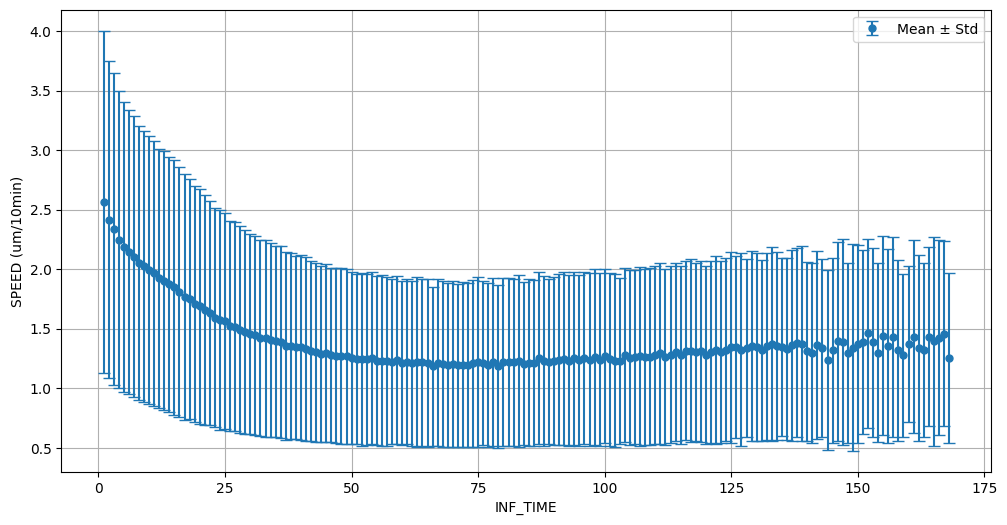

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.plot(df["INF_TIME"], df["SPEED"], label="SPEED")
plt.figure(figsize=(12, 6))
plt.errorbar(grouped["INF_TIME"], grouped["mean"], yerr=grouped["std"], fmt="o", label="Mean ± Std", markersize=5, capsize=4)
plt.grid(True)
plt.xlabel("INF_TIME")
plt.ylabel("SPEED (um/10min)")
plt.legend()

<Axes: xlabel='INF_TIME', ylabel='SPEED'>

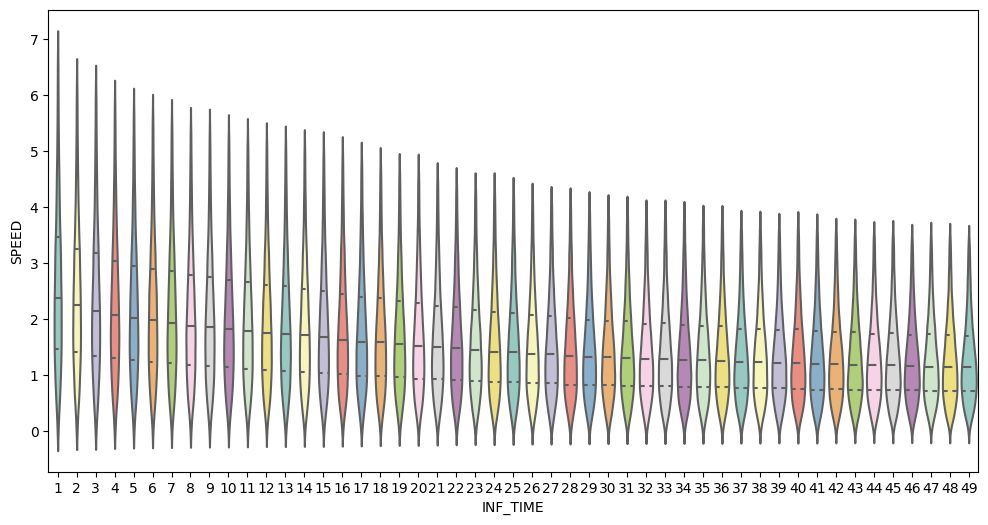

In [10]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="INF_TIME", y='SPEED', data=df[df["INF_TIME"] < 50], inner="quart", palette="Set3")

# Part 2: Calculate randomness in direction
Consider that cells move randomly, but the main direction they are going is
the average in a 10 window span of steps. Therefore, want std of one-step
movement direction w.r.t. the average window of directions.

In [11]:
df

,POSITION_X,POSITION_Y,FRAME,TRACK_ID,INF_TIME,BACKWARD_DIF_X,BACKWARD_DIF_Y,SPEED
0,1148.218727,903.201801,1,10_0,1,-1.221471,1.960242,2.309662
1,1133.822410,889.805849,1,10_1,1,0.361944,-0.163137,0.397011
2,1276.327674,805.749854,6,10_10,1,1.058527,-1.551623,1.878300
3,1246.135446,670.798963,19,10_100,1,1.990623,2.222653,2.983750
4,1385.380499,410.517044,69,10_1000,1,-3.174589,1.225816,3.403034
...,...,...,...,...,...,...,...,...
1656556,1067.433304,902.084821,168,9_4,168,-1.395569,-2.566901,2.921745
1656557,869.439731,657.316861,168,9_5,168,-0.766861,-0.619653,0.985924
1656558,1215.325960,801.352524,168,9_6,168,0.561687,-0.746242,0.934007
1656559,1165.858608,711.727203,168,9_7,168,0.457360,-1.439820,1.510715


In [39]:
HALF_WINDOW = 5

grouped = df.groupby("TRACK_ID")

df["CENTRAL_DIF_X"] = np.nan
df["CENTRAL_DIF_Y"] = np.nan

for _, group in grouped:
    sorted_group = group.sort_values(by="INF_TIME")
    value_x = (
        sorted_group["POSITION_X"].values[2 * HALF_WINDOW + 1:] -
        sorted_group["POSITION_X"].values[:-2 * HALF_WINDOW - 1]
    )
    value_y = (
        sorted_group["POSITION_Y"].values[2 * HALF_WINDOW + 1:] -
        sorted_group["POSITION_Y"].values[:-2 * HALF_WINDOW - 1]
    )
    df.loc[sorted_group.index[HALF_WINDOW + 1:-HALF_WINDOW], "CENTRAL_DIF_X"] = value_x
    df.loc[sorted_group.index[HALF_WINDOW + 1:-HALF_WINDOW], "CENTRAL_DIF_Y"] = value_y

df[df["CENTRAL_DIF_X"].notna()]

,POSITION_X,POSITION_Y,FRAME,TRACK_ID,INF_TIME,BACKWARD_DIF_X,BACKWARD_DIF_Y,SPEED,ONE_STEP_AHEAD_DIRECTION,CENTRAL_DIF_X,CENTRAL_DIF_Y
189181,1144.803119,916.701453,7,10_0,7,-0.266636,1.839490,1.858714,-0.266636,-5.996530,23.869575
189182,1131.305783,897.721818,7,10_1,7,-0.320998,1.961187,1.987284,-0.320998,-9.840396,17.108486
189183,1292.010937,806.045194,12,10_10,7,2.633716,-1.354334,2.961533,2.633716,31.349363,-1.469555
189185,1872.127253,396.977580,75,10_1001,7,1.192948,-0.118513,1.198820,1.192948,6.996988,0.057326
189186,1684.032440,587.527145,75,10_1003,7,0.617949,2.758612,2.826977,0.617949,-1.588479,29.557758
...,...,...,...,...,...,...,...,...,...,...,...
1655649,1067.874941,904.311049,163,9_4,163,0.403801,-0.417990,0.581181,0.403801,1.274014,-0.464374
1655650,868.532132,660.911934,163,9_5,163,1.138583,-1.073805,1.565065,1.138583,3.599514,-9.798764
1655651,1211.324434,801.843423,163,9_6,163,0.393024,-0.292597,0.489980,0.393024,7.397179,0.615310
1655652,1165.777338,712.536271,163,9_7,163,-0.192434,-2.169999,2.178514,-0.192434,-5.380191,0.084346


(array([ 9182.,  8978.,  9104.,  9249.,  9528.,  9768., 10368., 10713.,
        11394., 12024., 12926., 14224., 15702., 17222., 19173., 21836.,
        24678., 28706., 33562., 39265., 47068., 55088., 63788., 73158.,
        77665., 82555., 72894., 64303., 54881., 46354., 39120., 33457.,
        28541., 24844., 21732., 18957., 17244., 15392., 14010., 12977.,
        12206., 11303., 10856., 10246.,  9848.,  9461.,  9168.,  9143.,
         9082.,  9516.]),
 array([-180. , -172.8, -165.6, -158.4, -151.2, -144. , -136.8, -129.6,
        -122.4, -115.2, -108. , -100.8,  -93.6,  -86.4,  -79.2,  -72. ,
         -64.8,  -57.6,  -50.4,  -43.2,  -36. ,  -28.8,  -21.6,  -14.4,
          -7.2,    0. ,    7.2,   14.4,   21.6,   28.8,   36. ,   43.2,
          50.4,   57.6,   64.8,   72. ,   79.2,   86.4,   93.6,  100.8,
         108. ,  115.2,  122.4,  129.6,  136.8,  144. ,  151.2,  158.4,
         165.6,  172.8,  180. ]),
 <BarContainer object of 50 artists>)

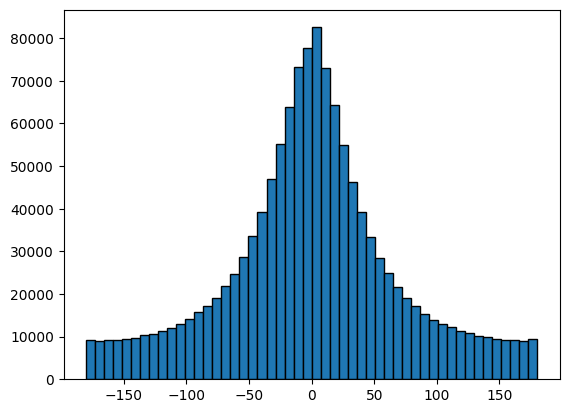

In [44]:
# Plot histogram of angle between backward_dif and the moving average
angles = np.arctan2(df['CENTRAL_DIF_Y'] * df['BACKWARD_DIF_X'] - df['CENTRAL_DIF_X'] * df['BACKWARD_DIF_Y'],
                    df['CENTRAL_DIF_X'] * df['BACKWARD_DIF_X'] + df['CENTRAL_DIF_Y'] * df['BACKWARD_DIF_Y'])

plt.hist(np.degrees(angles), bins=50, edgecolor='black')

# Part 3: Comparing different variations
WR, dF11, dVGF, dVGF/dF11

In [45]:
import pandas as pd

# Use IQR to remove outliers
def remove_outliers(group):
    Q1 = group["SPEED"].quantile(0.25)
    Q3 = group["SPEED"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group["SPEED"] > lower_bound) & (group["SPEED"] < upper_bound)]

def speed_vs_inftime(csv_files):
    """Get backward diff speed based on time of infection for given csv files of
    trackmate results."""
    # Read the csv data in csv_files and only keep a selection of columns. Also add
    # the number of in the file name to the TRACK_ID column with - in between
    dfs = []
    keep_cols = ["POSITION_X", "POSITION_Y", "FRAME", "TRACK_ID"]
    for f in csv_files:
        df = pd.read_csv(os.path.join(CSV_ROOT, f), skiprows=[1, 2, 3], low_memory=False)
        df["TRACK_ID"] = f.split("-")[0] + '_' + df['TRACK_ID'].astype(str)
        df = df[keep_cols]
        dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)

    # Add column to it called INF_TIME that for each track id finds the one with the
    # lowest frame number and substracts this from the frame number for all entries
    # with the same TRACK_ID
    df["INF_TIME"] = df["FRAME"] - df.groupby("TRACK_ID")["FRAME"].transform(min)

    # Create new column called FORWARD_DIF_X that subtracks the value of POSITION_X
    # with the value for the entry with same TRACK_ID but INF_TIME-1 (if INF_TIME is
    # 0 then just put 0 in it)
    df.sort_values(by=["TRACK_ID", "INF_TIME"], inplace=True)
    df["BACKWARD_DIF_X"] = df.groupby("TRACK_ID")["POSITION_X"].diff().fillna(0)  # diff does the forward difference
    df["BACKWARD_DIF_Y"] = df.groupby("TRACK_ID")["POSITION_Y"].diff().fillna(0)

    df["SPEED"] = np.sqrt(df["BACKWARD_DIF_X"]**2 + df["BACKWARD_DIF_Y"]**2)

    df = df.groupby("INF_TIME").apply(remove_outliers).reset_index(drop=True)

    return df.groupby("INF_TIME")["SPEED"].agg(["mean", "std"]).reset_index()

In [49]:
import matplotlib.pyplot as plt

CSV_ROOT = "../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061"

csv_files_WR = [f for f in os.listdir(CSV_ROOT) if f.endswith(".csv") and int(f.split("-")[0]) in range(1, 16)]
csv_files_dVGF = [f for f in os.listdir(CSV_ROOT) if f.endswith(".csv") and int(f.split("-")[0]) in range(16, 31)]
csv_files_dF11 = [f for f in os.listdir(CSV_ROOT) if f.endswith(".csv") and int(f.split("-")[0]) in range(31, 46)]
csv_files_both = [f for f in os.listdir(CSV_ROOT) if f.endswith(".csv") and int(f.split("-")[0]) in range(46, 61)]

speed_1 = speed_vs_inftime(csv_files_WR)
speed_2 = speed_vs_inftime(csv_files_dVGF)
speed_3 = speed_vs_inftime(csv_files_dF11)
speed_4 = speed_vs_inftime(csv_files_both)

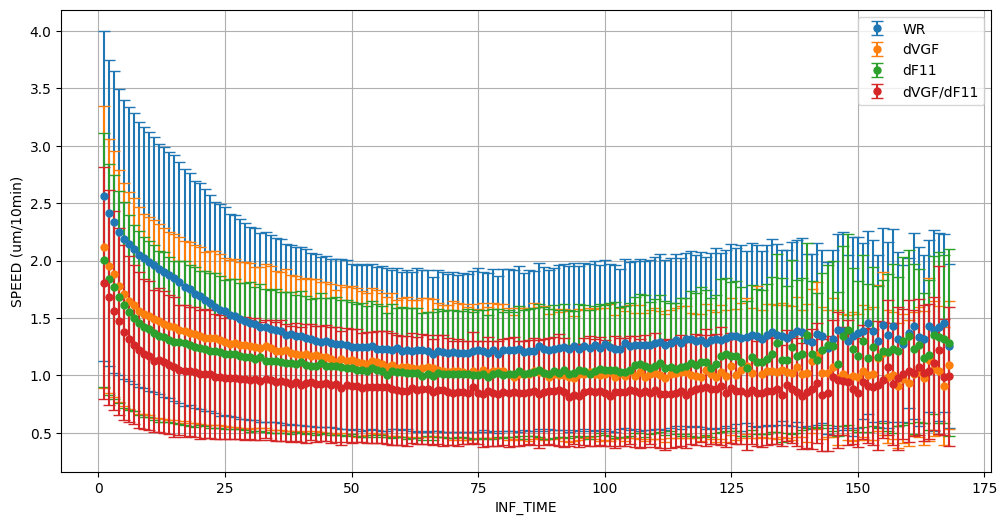

In [51]:
plt.figure(figsize=(12, 6))
plt.errorbar(speed_1["INF_TIME"], speed_1["mean"], yerr=speed_1["std"], fmt="o", label="WR", markersize=5, capsize=4)
plt.errorbar(speed_2["INF_TIME"], speed_2["mean"], yerr=speed_2["std"], fmt="o", label="dVGF", markersize=5, capsize=4)
plt.errorbar(speed_3["INF_TIME"], speed_3["mean"], yerr=speed_3["std"], fmt="o", label="dF11", markersize=5, capsize=4)
plt.errorbar(speed_4["INF_TIME"], speed_4["mean"], yerr=speed_4["std"], fmt="o", label="dVGF/dF11", markersize=5, capsize=4)
plt.grid(True)
plt.xlabel("INF_TIME")
plt.ylabel("SPEED (um/10min)")
plt.legend()